In [ ]:
!apt-get install openjdk-21-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz
!tar xf spark-3.5.5-bin-hadoop3.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-21-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.5-bin-hadoop3"

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error,r2_score
from math import sqrt
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import cross_val_score ,GridSearchCV , train_test_split
from sklearn.preprocessing import LabelEncoder
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import to_timestamp,unix_timestamp, col
from pyspark.sql import functions as F
from pyspark.ml.regression import RandomForestRegressor,LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, to_date, sum as spark_sum, avg as spark_avg, count as spark_count, month, year,when
from pyspark.sql.window import Window
import matplotlib.ticker as ticker
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
spark = SparkSession.builder \
        .appName("SalesDataAnalysis") \
        .config("spark.sql.shuffle.partitions", "200") \
        .config("spark.executor.memory", "4g") \
        .getOrCreate()
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")


In [ ]:
file_path = "/content/drive/MyDrive/DATA/sales_data_sample.csv"

df = spark.read.csv(file_path, header=True, inferSchema=True)

df.head()


Row(ORDERNUMBER=10107, QUANTITYORDERED=30, PRICEEACH=95.7, ORDERLINENUMBER=2, SALES=2871.0, ORDERDATE='2/24/2003 0:00', STATUS='Shipped', QTR_ID=1, MONTH_ID=2, YEAR_ID=2003, PRODUCTLINE='Motorcycles', MSRP=95, PRODUCTCODE='S10_1678', CUSTOMERNAME='Land of Toys Inc.', PHONE='2125557818', ADDRESSLINE1='897 Long Airport Avenue', ADDRESSLINE2=None, CITY='NYC', STATE='NY', POSTALCODE='10022', COUNTRY='USA', TERRITORY='NA', CONTACTLASTNAME='Yu', CONTACTFIRSTNAME='Kwai', DEALSIZE='Small')

In [ ]:
# Giữ lại các dòng có dữ liệu ở các cột quan trọng: SALES, ORDERDATE, CUSTOMERNAME
df_clean = df.dropna(subset=["SALES", "ORDERDATE", "CUSTOMERNAME"])
df_clean = df_clean.filter(col("SALES") >= 0)
df_clean = df_clean.withColumn("ORDERDATE", to_timestamp(col("ORDERDATE"), "M/d/yyyy H:mm").cast("date"))
# Cache dữ liệu để tăng tốc các phép tính sau này
df_clean.cache()

DataFrame[ORDERNUMBER: int, QUANTITYORDERED: int, PRICEEACH: double, ORDERLINENUMBER: int, SALES: double, ORDERDATE: date, STATUS: string, QTR_ID: int, MONTH_ID: int, YEAR_ID: int, PRODUCTLINE: string, MSRP: int, PRODUCTCODE: string, CUSTOMERNAME: string, PHONE: string, ADDRESSLINE1: string, ADDRESSLINE2: string, CITY: string, STATE: string, POSTALCODE: string, COUNTRY: string, TERRITORY: string, CONTACTLASTNAME: string, CONTACTFIRSTNAME: string, DEALSIZE: string]

#EDA

In [ ]:
df_clean.select("ORDERDATE").distinct().show(10, truncate=False)


+----------+
|ORDERDATE |
+----------+
|2003-11-11|
|2003-07-16|
|2004-11-01|
|2004-11-05|
|2003-10-11|
|2004-05-04|
|2003-05-07|
|2005-02-23|
|2004-12-03|
|2003-11-06|
+----------+
only showing top 10 rows



In [ ]:
# In schema và thống kê cơ bản
print("Schema:")
df_clean.printSchema()
print("Descriptive Statistics for SALES, QUANTITYORDERED, PRICEEACH, MSRP:")
df_clean.describe("SALES", "QUANTITYORDERED", "PRICEEACH", "MSRP").show()
# 1. Tổng doanh số theo ngày
total_sales_by_date = df_clean.groupBy("ORDERDATE") \
                              .agg(spark_sum("SALES").alias("total_sales")) \
                              .orderBy("ORDERDATE")
print("Total Sales by Order Date:")
total_sales_by_date.show(10)


Schema:
root
 |-- ORDERNUMBER: integer (nullable = true)
 |-- QUANTITYORDERED: integer (nullable = true)
 |-- PRICEEACH: double (nullable = true)
 |-- ORDERLINENUMBER: integer (nullable = true)
 |-- SALES: double (nullable = true)
 |-- ORDERDATE: date (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- QTR_ID: integer (nullable = true)
 |-- MONTH_ID: integer (nullable = true)
 |-- YEAR_ID: integer (nullable = true)
 |-- PRODUCTLINE: string (nullable = true)
 |-- MSRP: integer (nullable = true)
 |-- PRODUCTCODE: string (nullable = true)
 |-- CUSTOMERNAME: string (nullable = true)
 |-- PHONE: string (nullable = true)
 |-- ADDRESSLINE1: string (nullable = true)
 |-- ADDRESSLINE2: string (nullable = true)
 |-- CITY: string (nullable = true)
 |-- STATE: string (nullable = true)
 |-- POSTALCODE: string (nullable = true)
 |-- COUNTRY: string (nullable = true)
 |-- TERRITORY: string (nullable = true)
 |-- CONTACTLASTNAME: string (nullable = true)
 |-- CONTACTFIRSTNAME: string (nullabl

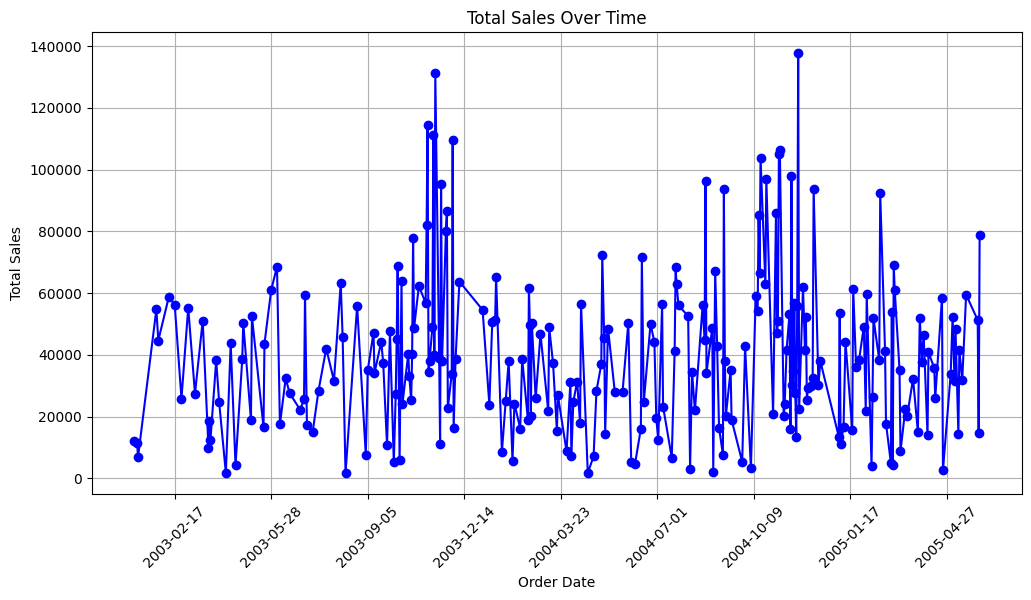

In [ ]:
sales_pd = total_sales_by_date.toPandas()
plt.figure(figsize=(12,6))
plt.plot(sales_pd["ORDERDATE"], sales_pd["total_sales"], marker="o", linestyle="-", color="b")
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(10))
plt.title("Total Sales Over Time")
plt.xlabel("Order Date")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

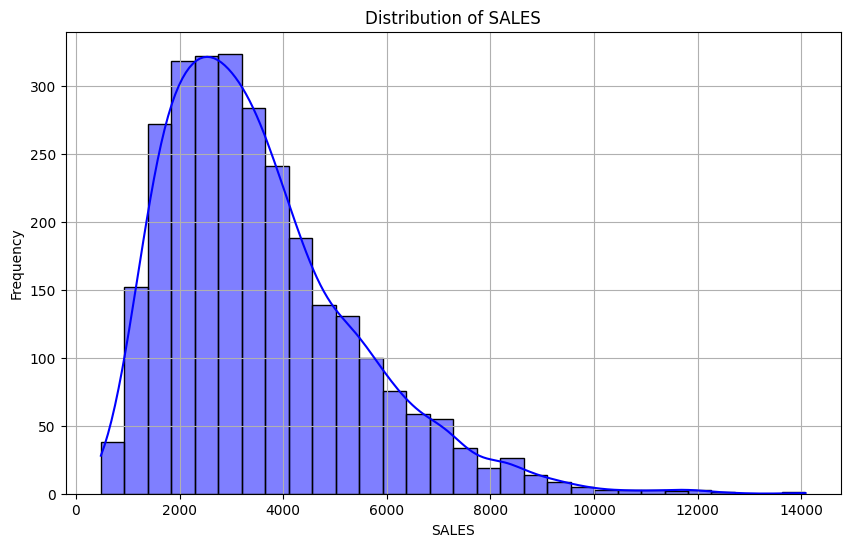

In [ ]:
sales_pd = df_clean.select("SALES").toPandas()

plt.figure(figsize=(10,6))
sns.histplot(sales_pd["SALES"], bins=30, kde=True, color='blue')
plt.title("Distribution of SALES")
plt.xlabel("SALES")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


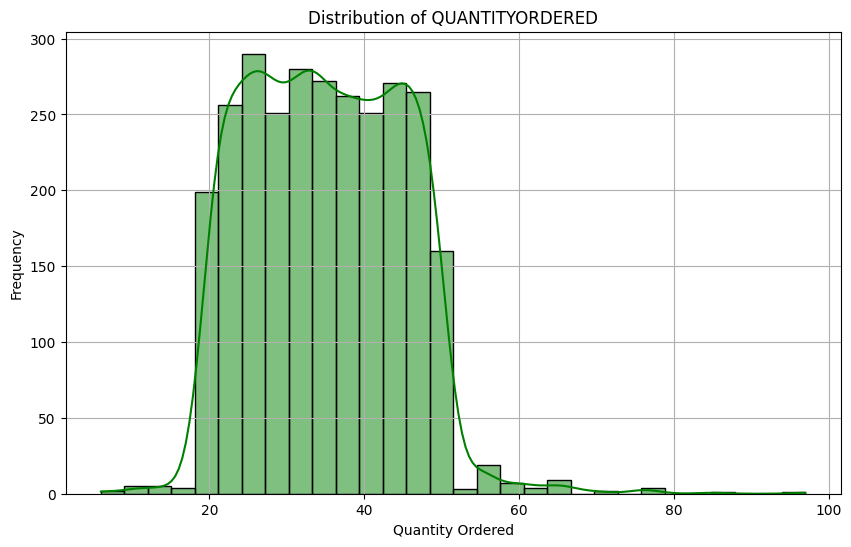

In [ ]:
qty_pd = df_clean.select("QUANTITYORDERED").toPandas()

plt.figure(figsize=(10,6))
sns.histplot(qty_pd["QUANTITYORDERED"], bins=30, kde=True, color='green')
plt.title("Distribution of QUANTITYORDERED")
plt.xlabel("Quantity Ordered")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

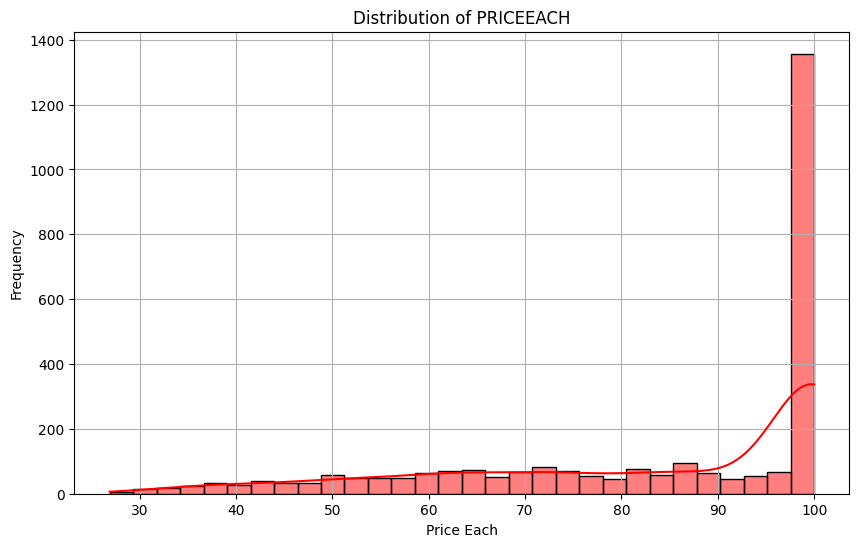

In [ ]:
price_pd = df_clean.select("PRICEEACH").toPandas()

plt.figure(figsize=(10,6))
sns.histplot(price_pd["PRICEEACH"], bins=30, kde=True, color='red')
plt.title("Distribution of PRICEEACH")
plt.xlabel("Price Each")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

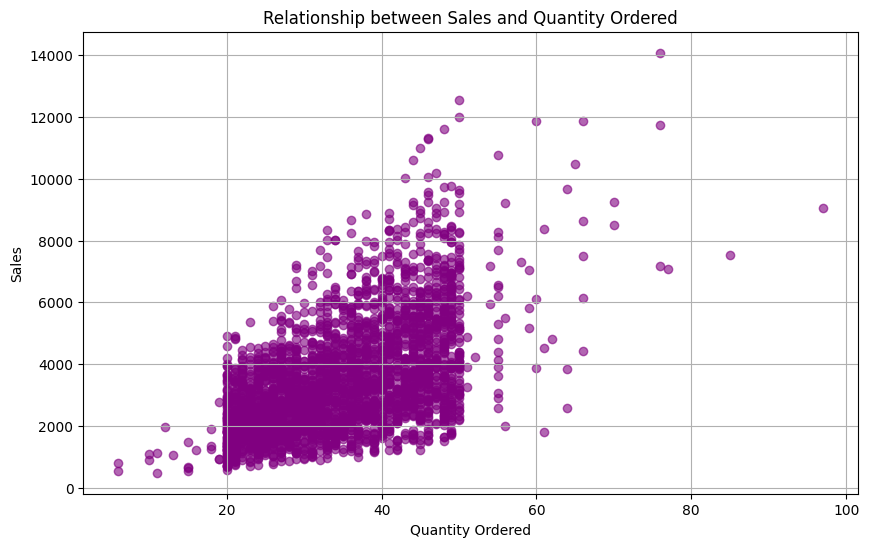

In [ ]:
df_pd = df_clean.select("SALES", "QUANTITYORDERED", "PRICEEACH").toPandas()

# 1. Trực quan hóa mối quan hệ giữa doanh thu và số lượng đơn hàng
plt.figure(figsize=(10,6))
plt.scatter(df_pd["QUANTITYORDERED"], df_pd["SALES"], alpha=0.6, color="purple")
plt.title("Relationship between Sales and Quantity Ordered")
plt.xlabel("Quantity Ordered")
plt.ylabel("Sales")
plt.grid(True)
plt.show()

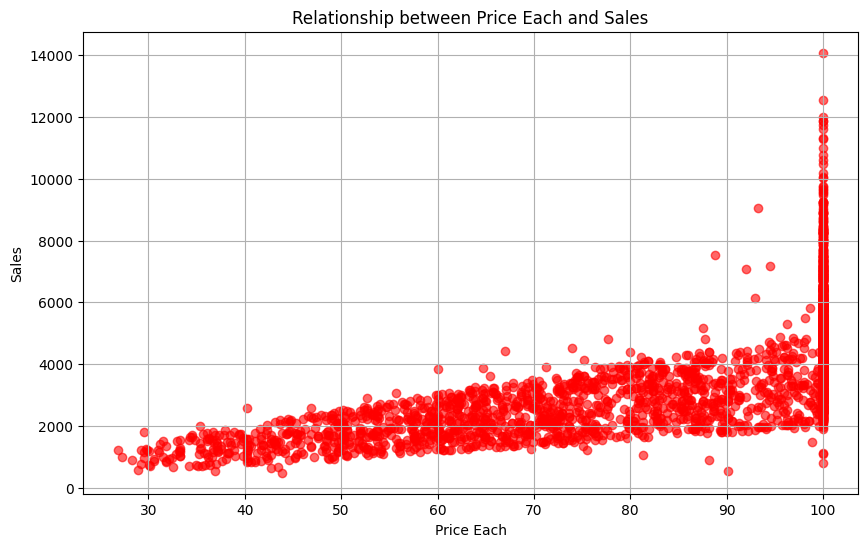

In [ ]:
# 2. Trực quan hóa mối quan hệ giữa giá mỗi sản phẩm và doanh thu
plt.figure(figsize=(10,6))
plt.scatter(df_pd["PRICEEACH"], df_pd["SALES"], alpha=0.6, color="red")
plt.title("Relationship between Price Each and Sales")
plt.xlabel("Price Each")
plt.ylabel("Sales")
plt.grid(True)
plt.show()

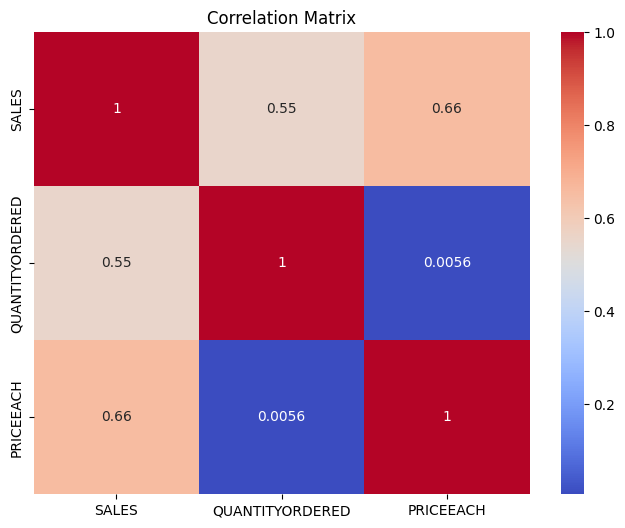

In [ ]:
corr_matrix = df_pd[["SALES", "QUANTITYORDERED", "PRICEEACH"]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

            total_sales
ORDERDATE              
2003-01-06     12133.25
2003-01-09     11432.34
2003-01-10      6864.05
2003-01-29     54702.00
2003-01-31     44621.96


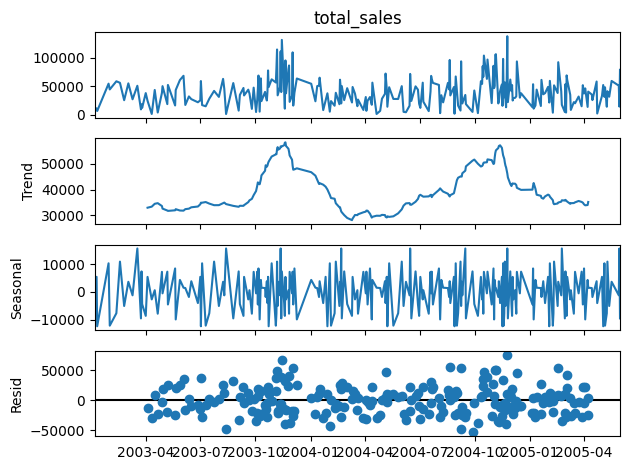

In [ ]:
sales_pd = total_sales_by_date.toPandas()
# Sắp xếp theo ORDERDATE
sales_pd.sort_values(by="ORDERDATE", inplace=True)
# Đặt ORDERDATE làm index
sales_pd.set_index("ORDERDATE", inplace=True)

# Kiểm tra vài dòng dữ liệu
print(sales_pd.head())

# Áp dụng seasonal_decompose với model 'additive'
# Giả sử chu kỳ là 30 ngày (điều chỉnh nếu cần)
decomposition = seasonal_decompose(sales_pd["total_sales"], model='additive', period=30)

# Vẽ biểu đồ decomposition: trend, seasonal, residual
decomposition.plot()
plt.tight_layout()
plt.show()


Sales Histogram:
Bin 482.13 - 1842.1970000000001: Count = 462
Bin 1842.1970000000001 - 3202.264: Count = 965
Bin 3202.264 - 4562.331: Count = 713
Bin 4562.331 - 5922.398: Count = 370
Bin 5922.398 - 7282.465: Count = 190
Bin 7282.465 - 8642.532: Count = 79
Bin 8642.532 - 10002.599: Count = 28
Bin 10002.599 - 11362.666: Count = 9
Bin 11362.666 - 12722.732999999998: Count = 6
Bin 12722.732999999998 - 14082.8: Count = 1
Top-selling Product Lines:
+----------------+------------------+
|     PRODUCTLINE|       total_sales|
+----------------+------------------+
|    Classic Cars| 3919615.659999997|
|    Vintage Cars|1903150.8399999992|
|     Motorcycles|1166388.3400000003|
|Trucks and Buses|1127789.8399999996|
|          Planes| 975003.5700000001|
|           Ships|         714437.13|
|          Trains|226243.46999999997|
+----------------+------------------+



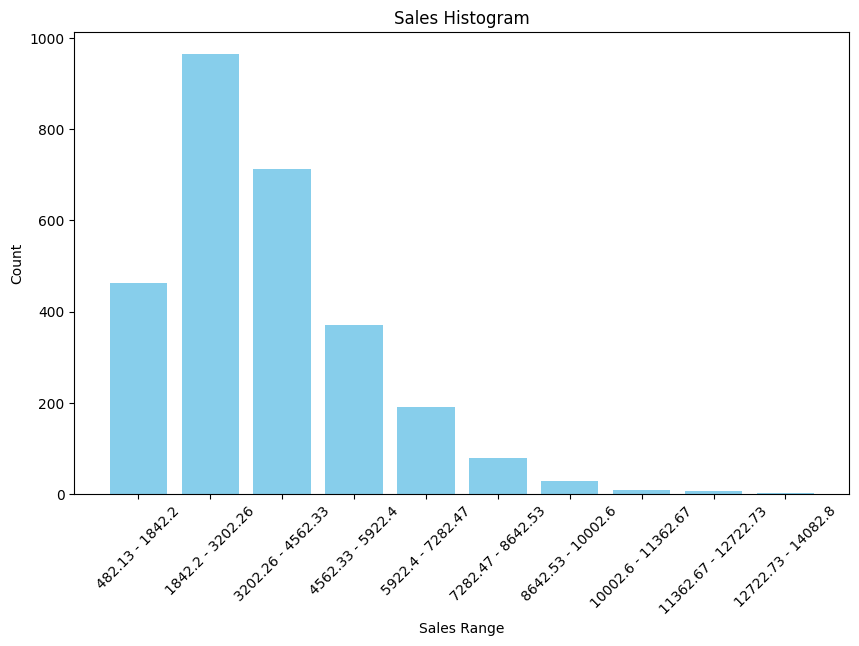

In [ ]:
sales_rdd = df_clean.select("SALES").rdd.flatMap(lambda x: x)
bins, counts = sales_rdd.histogram(10)
print("Sales Histogram:")
for i in range(len(bins)-1):
    print(f"Bin {bins[i]} - {bins[i+1]}: Count = {counts[i]}")

# 3. Doanh số theo PRODUCTLINE (Top sản phẩm)
top_products = df_clean.groupBy("PRODUCTLINE") \
                       .agg(spark_sum("SALES").alias("total_sales")) \
                       .orderBy(col("total_sales").desc())
print("Top-selling Product Lines:")
top_products.show(10)
bin_labels = [f"{round(bins[i], 2)} - {round(bins[i+1], 2)}" for i in range(len(bins)-1)]

plt.figure(figsize=(10,6))
plt.bar(range(len(counts)), counts, tick_label=bin_labels, color="skyblue")
plt.title("Sales Histogram")
plt.xlabel("Sales Range")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

Top-selling Product Lines:
+----------------+------------------+
|     PRODUCTLINE|       total_sales|
+----------------+------------------+
|    Classic Cars| 3919615.659999997|
|    Vintage Cars|1903150.8399999992|
|     Motorcycles|1166388.3400000003|
|Trucks and Buses|1127789.8399999996|
|          Planes| 975003.5700000001|
|           Ships|         714437.13|
|          Trains|226243.46999999997|
+----------------+------------------+



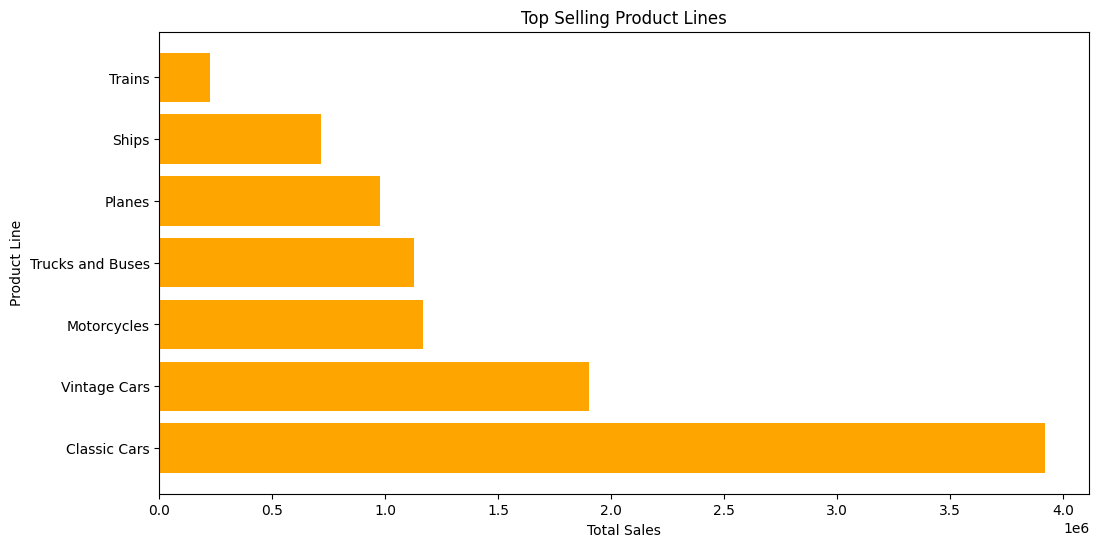

In [ ]:
top_products = df_clean.groupBy("PRODUCTLINE") \
                       .agg(spark_sum("SALES").alias("total_sales")) \
                       .orderBy(col("total_sales").desc())
print("Top-selling Product Lines:")
top_products.show(10)
top_products_pd = top_products.toPandas()

plt.figure(figsize=(12,6))
plt.barh(top_products_pd["PRODUCTLINE"], top_products_pd["total_sales"], color="orange")
plt.title("Top Selling Product Lines")
plt.xlabel("Total Sales")
plt.ylabel("Product Line")
plt.show()

Order Status Distribution:
+----------+-----+
|    STATUS|count|
+----------+-----+
|   Shipped| 2617|
| Cancelled|   60|
|  Resolved|   47|
|   On Hold|   44|
|In Process|   41|
|  Disputed|   14|
+----------+-----+



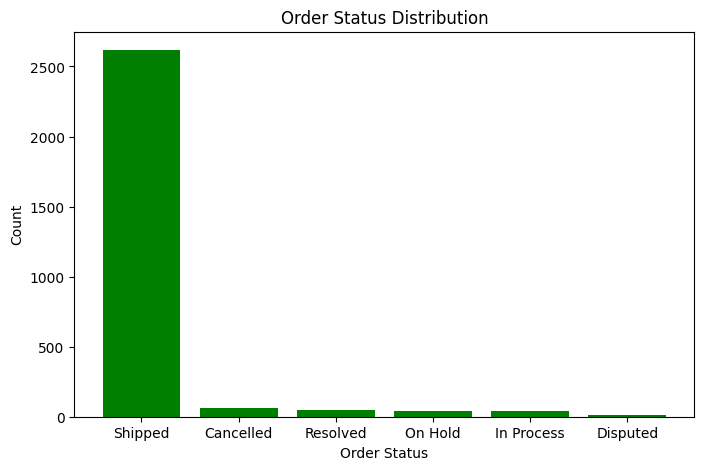

In [ ]:
order_status = df_clean.groupBy("STATUS").count().orderBy("count", ascending=False)
print("Order Status Distribution:")
order_status.show()
order_status_pd = order_status.toPandas()

plt.figure(figsize=(8,5))
plt.bar(order_status_pd["STATUS"], order_status_pd["count"], color="green")
plt.title("Order Status Distribution")
plt.xlabel("Order Status")
plt.ylabel("Count")
plt.show()

Correlation between SALES and QUANTITYORDERED: 0.5514261919183588
Correlation between SALES and PRICEEACH: 0.657840928317687
Total Sales by Month:
+-----+------------------+
|Month|       total_sales|
+-----+------------------+
|    1| 785874.4400000008|
|    2|          810441.9|
|    3| 754501.3900000001|
|    4| 669390.9600000003|
|    5|         923972.56|
|    6|454756.77999999985|
|    7| 514875.9700000001|
|    8| 659310.5699999998|
|    9| 584724.2699999999|
|   10|1121215.2199999997|
|   11|        2118885.67|
|   12| 634679.1199999998|
+-----+------------------+



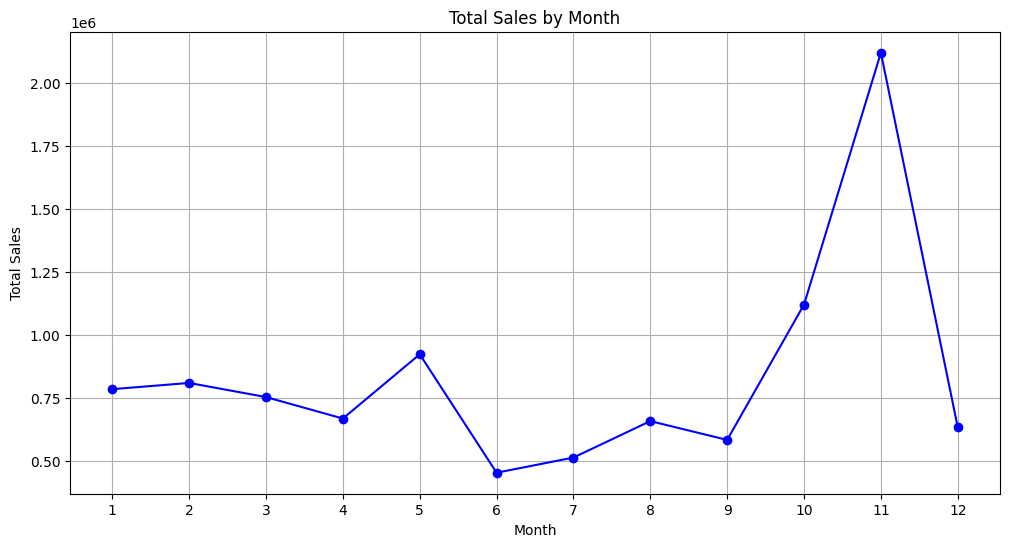

In [ ]:
corr_sales_qty = df_clean.stat.corr("SALES", "QUANTITYORDERED")
corr_sales_price = df_clean.stat.corr("SALES", "PRICEEACH")
print(f"Correlation between SALES and QUANTITYORDERED: {corr_sales_qty}")
print(f"Correlation between SALES and PRICEEACH: {corr_sales_price}")

# Thêm cột 'Month' từ ORDERDATE
df_clean = df_clean.withColumn("Month", month(col("ORDERDATE")))
sales_by_month = df_clean.groupBy("Month") \
                         .agg(spark_sum("SALES").alias("total_sales")) \
                         .orderBy("Month")
print("Total Sales by Month:")
sales_by_month.show()

# Chuyển kết quả tổng hợp sang Pandas để trực quan hóa
sales_by_month_pd = sales_by_month.toPandas()
plt.figure(figsize=(12,6))
plt.plot(sales_by_month_pd["Month"], sales_by_month_pd["total_sales"], marker="o", linestyle="-", color="blue")
plt.title("Total Sales by Month")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

30-Day Moving Average for Sales:
+----------+------------------+------------------+
| ORDERDATE|       total_sales|             MA_30|
+----------+------------------+------------------+
|2003-01-06|          12133.25|          12133.25|
|2003-01-09|          11432.34|         11782.795|
|2003-01-10|           6864.05|10143.213333333333|
|2003-01-29| 54701.99999999999|21282.909999999996|
|2003-01-31| 44621.95999999999|25950.719999999994|
|2003-02-11|          58871.11| 31437.45166666666|
|2003-02-17|          56181.32| 34972.28999999999|
|2003-02-24|25783.760000000002|       33823.72375|
|2003-03-03|55245.020000000004| 36203.86777777778|
|2003-03-10|          27398.82|         35323.363|
+----------+------------------+------------------+
only showing top 10 rows



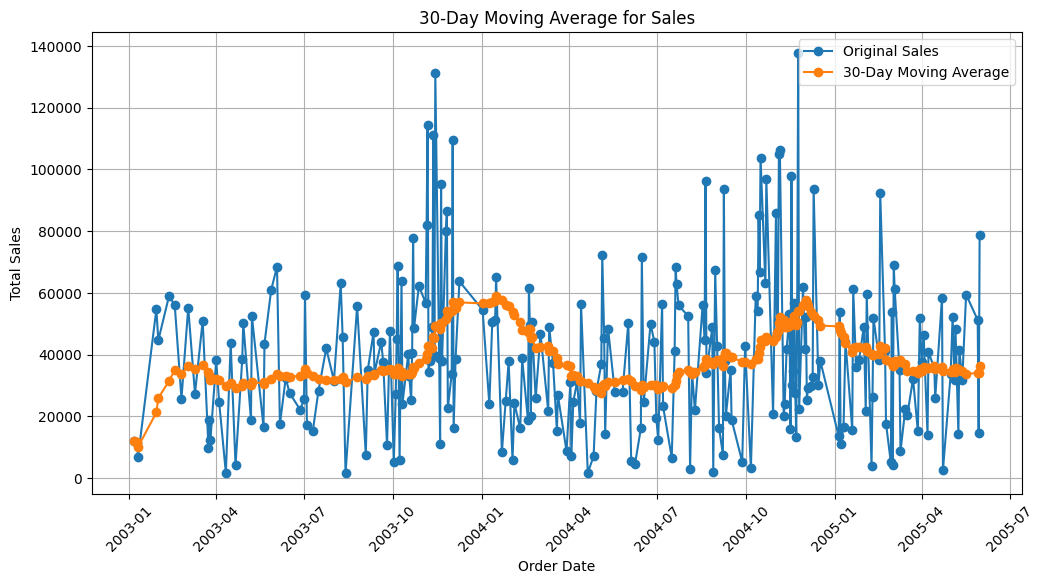

In [ ]:
window_spec = Window.orderBy("ORDERDATE").rowsBetween(-29, 0)
sales_ma = total_sales_by_date.withColumn("MA_30", spark_avg("total_sales").over(window_spec))
print("30-Day Moving Average for Sales:")
sales_ma.show(10)
sales_ma_pd = sales_ma.toPandas()
sales_ma_pd.sort_values(by="ORDERDATE", inplace=True)

# Vẽ biểu đồ so sánh doanh số gốc và Moving Average
plt.figure(figsize=(12,6))
plt.plot(sales_ma_pd['ORDERDATE'], sales_ma_pd['total_sales'], marker='o', linestyle='-', label='Original Sales')
plt.plot(sales_ma_pd['ORDERDATE'], sales_ma_pd['MA_30'], marker='o', linestyle='-', label='30-Day Moving Average')
plt.title("30-Day Moving Average for Sales")
plt.xlabel("Order Date")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
sales_series = total_sales_by_date.select("total_sales").rdd.flatMap(lambda x: x).collect()
adf_test = adfuller(sales_series)
adf_result = {
    "ADF Statistic": adf_test[0],
    "p-value": adf_test[1],
    "Critical Values": adf_test[4]
}
print("ADF Test Result:")
adf_result

ADF Test Result:


{'ADF Statistic': np.float64(-3.760314601852617),
 'p-value': np.float64(0.00334047057902041),
 'Critical Values': {'1%': np.float64(-3.4573260719088132),
  '5%': np.float64(-2.873410402808354),
  '10%': np.float64(-2.573095980841316)}}

Number of Outliers Detected: 30
+-----------+---------------+---------+---------------+-------+----------+----------+------+--------+-------+------------+----+-----------+--------------------+--------------+--------------------+------------+----------+--------+----------+---------+---------+---------------+----------------+--------+-----+
|ORDERNUMBER|QUANTITYORDERED|PRICEEACH|ORDERLINENUMBER|  SALES| ORDERDATE|    STATUS|QTR_ID|MONTH_ID|YEAR_ID| PRODUCTLINE|MSRP|PRODUCTCODE|        CUSTOMERNAME|         PHONE|        ADDRESSLINE1|ADDRESSLINE2|      CITY|   STATE|POSTALCODE|  COUNTRY|TERRITORY|CONTACTLASTNAME|CONTACTFIRSTNAME|DEALSIZE|Month|
+-----------+---------------+---------+---------------+-------+----------+----------+------+--------+-------+------------+----+-----------+--------------------+--------------+--------------------+------------+----------+--------+----------+---------+---------+---------------+----------------+--------+-----+
|      10150|             45|    100.0|  

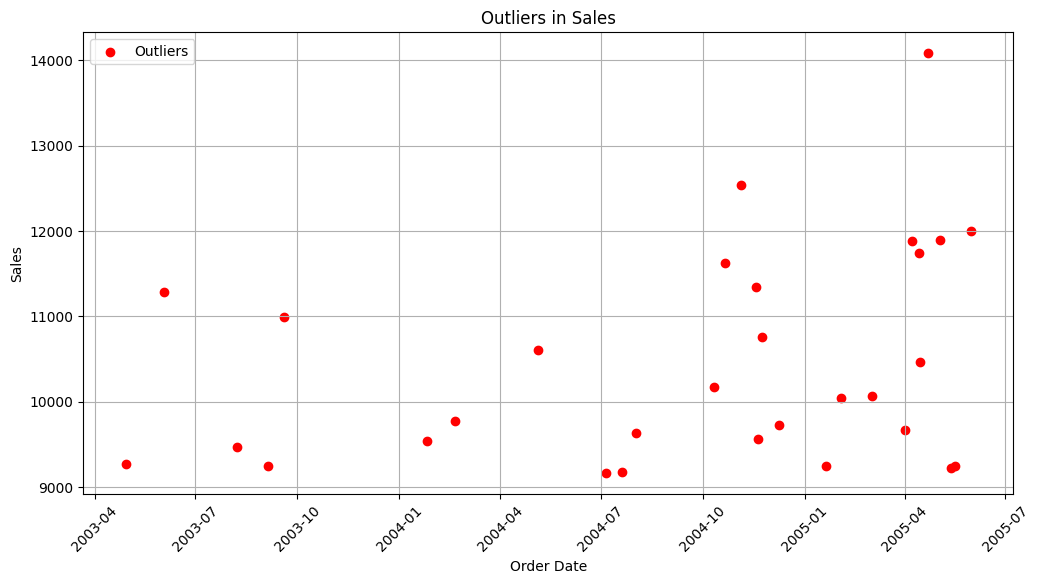

In [ ]:
stats_df = df_clean.select(spark_avg("SALES").alias("mean"), F.stddev("SALES").alias("stddev")).collect()[0]
mean_sales = stats_df["mean"]
stddev_sales = stats_df["stddev"]
df_outliers = df_clean.filter((col("SALES") < mean_sales - 3*stddev_sales) | (col("SALES") > mean_sales + 3*stddev_sales))
print("Number of Outliers Detected:", df_outliers.count())
df_outliers.show(10)
df_outliers_pd = df_outliers.toPandas()
plt.figure(figsize=(12,6))
plt.scatter(df_outliers_pd["ORDERDATE"], df_outliers_pd["SALES"], color="red", label="Outliers")
plt.title("Outliers in Sales")
plt.xlabel("Order Date")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df_replaced = df_clean.withColumn("SALES_REPLACED",
                                  when((col("SALES") < mean_sales - 3*stddev_sales) | (col("SALES") > mean_sales + 3*stddev_sales),
                                       mean_sales).otherwise(col("SALES")))
print("Sample of Sales after Outlier Replacement:")
df_replaced.select("ORDERDATE", "SALES", "SALES_REPLACED").show(10)

Sample of Sales after Outlier Replacement:
+----------+-------+--------------+
| ORDERDATE|  SALES|SALES_REPLACED|
+----------+-------+--------------+
|2003-02-24| 2871.0|        2871.0|
|2003-05-07| 2765.9|        2765.9|
|2003-07-01|3884.34|       3884.34|
|2003-08-25| 3746.7|        3746.7|
|2003-10-10|5205.27|       5205.27|
|2003-10-28|3479.76|       3479.76|
|2003-11-11|2497.77|       2497.77|
|2003-11-18|5512.32|       5512.32|
|2003-12-01|2168.54|       2168.54|
|2004-01-15|4708.44|       4708.44|
+----------+-------+--------------+
only showing top 10 rows



In [ ]:
df_feat = df_replaced.withColumn("MONTH", month(col("ORDERDATE"))) \
              .withColumn("YEAR", year(col("ORDERDATE")))

# Tổng doanh số theo khách hàng
sales_per_customer = df_feat.groupBy("CUSTOMERNAME") \
                            .agg(spark_sum("SALES").alias("customer_total_sales"))
print("Sample of total sales per customer:")
sales_per_customer.show(5)

# Trung bình doanh số theo sản phẩm (PRODUCTLINE)
avg_purchase_per_product = df_feat.groupBy("PRODUCTLINE") \
                                  .agg(spark_avg("SALES").alias("avg_sales"))
print("Average sales per product line:")
avg_purchase_per_product.show(5)

# Ví dụ tạo biến nhị phân: 1 nếu là mùa cao điểm (giả sử tháng 12), 0 nếu không
df_feat = df_feat.withColumn("IS_PEAK_SEASON", when(col("MONTH") == 12, 1).otherwise(0))

Sample of total sales per customer:
+--------------------+--------------------+
|        CUSTOMERNAME|customer_total_sales|
+--------------------+--------------------+
| Suominen Souveniers|  113961.14999999997|
|  Amica Models & Co.|   94117.26000000002|
|Collectables For ...|            81577.98|
|         CAF Imports|            49642.05|
|   giftsbymail.co.uk|   78240.83999999998|
+--------------------+--------------------+
only showing top 5 rows

Average sales per product line:
+----------------+------------------+
|     PRODUCTLINE|         avg_sales|
+----------------+------------------+
|     Motorcycles| 3523.831842900303|
|    Vintage Cars|3135.3391103789113|
|           Ships| 3053.150128205128|
|Trucks and Buses|3746.8100996677726|
|    Classic Cars|4053.3771044467394|
+----------------+------------------+
only showing top 5 rows



In [ ]:
df_feat.select("ORDERDATE", "MONTH", "YEAR").show(10)


+----------+-----+----+
| ORDERDATE|MONTH|YEAR|
+----------+-----+----+
|2003-02-24|    2|2003|
|2003-05-07|    5|2003|
|2003-07-01|    7|2003|
|2003-08-25|    8|2003|
|2003-10-10|   10|2003|
|2003-10-28|   10|2003|
|2003-11-11|   11|2003|
|2003-11-18|   11|2003|
|2003-12-01|   12|2003|
|2004-01-15|    1|2004|
+----------+-----+----+
only showing top 10 rows



Monthly Sales Trends:
+----+-----+------------------+
|YEAR|MONTH|     monthly_sales|
+----+-----+------------------+
|2003|    1|          129753.6|
|2003|    2|140836.19000000003|
|2003|    3|          174504.9|
|2003|    4|201609.55000000002|
|2003|    5|         192673.11|
|2003|    6|168082.55999999997|
|2003|    7|187731.87999999998|
|2003|    8|          197809.3|
|2003|    9|         263973.36|
|2003|   10|         568290.97|
+----+-----+------------------+
only showing top 10 rows



<Figure size 1200x600 with 0 Axes>

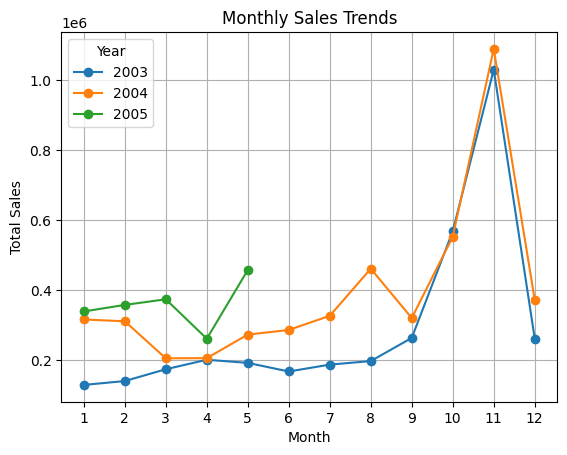

In [ ]:
monthly_trends = df_feat.groupBy("YEAR", "MONTH") \
                      .agg(spark_sum("SALES").alias("monthly_sales")) \
                      .orderBy("YEAR", "MONTH")
print("Monthly Sales Trends:")
monthly_trends.show(10)
monthly_trends_pd = monthly_trends.toPandas()
monthly_pivot = monthly_trends_pd.pivot(index='MONTH', columns='YEAR', values='monthly_sales')
plt.figure(figsize=(12,6))
monthly_pivot.plot(marker='o', linestyle='-')
plt.title("Monthly Sales Trends")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.xticks(range(1,13))
plt.grid(True)
plt.legend(title="Year")
plt.show()

In [ ]:
# Lấy dữ liệu, chọn cột SALES và QUANTITYORDERED, loại bỏ giá trị null
cluster_data = df_feat.select("SALES", "QUANTITYORDERED").na.drop()

# Bước 1: Gom các cột thành một vector (chưa chuẩn hóa)
assembler_cluster = VectorAssembler(inputCols=["SALES", "QUANTITYORDERED"], outputCol="raw_features")

# Bước 2: Chuẩn hóa các đặc trưng
scaler = StandardScaler(inputCol="raw_features", outputCol="features", withMean=True, withStd=True)

# Bước 3: Áp dụng KMeans với 3 cụm và seed cố định
kmeans = KMeans(k=3, seed=42, featuresCol="features")

# Xây dựng Pipeline gồm các bước: Assemble -> Scale -> KMeans
pipeline = Pipeline(stages=[assembler_cluster, scaler, kmeans])

# Huấn luyện mô hình clustering
model = pipeline.fit(cluster_data)

# Lấy kết quả clustering
clusters = model.transform(cluster_data)

# In ra các cụm trung tâm (lấy từ bước KMeans trong pipeline)
print("KMeans Cluster Centers:")
centers = model.stages[-1].clusterCenters()
for center in centers:
    print(center)

# Hiển thị 5 dòng đầu của cột features (đã chuẩn hóa)
clusters.select("features").show(5)

KMeans Cluster Centers:
[-0.61051553 -0.90732342]
[1.63189447 0.98901815]
[-0.08976953  0.59857007]
+--------------------+
|            features|
+--------------------+
|[-0.3707595468208...|
|[-0.4278212717389...|
|[0.17941103670449...|
|[0.10468243710670...|
|[0.89658082068233...|
+--------------------+
only showing top 5 rows



+-------+---------------+--------------------+----------+
|  SALES|QUANTITYORDERED|            features|prediction|
+-------+---------------+--------------------+----------+
| 2871.0|             30|[-0.3707595468208...|         0|
| 2765.9|             34|[-0.4278212717389...|         2|
|3884.34|             41|[0.17941103670449...|         2|
| 3746.7|             45|[0.10468243710670...|         2|
|5205.27|             49|[0.89658082068233...|         1|
+-------+---------------+--------------------+----------+
only showing top 5 rows



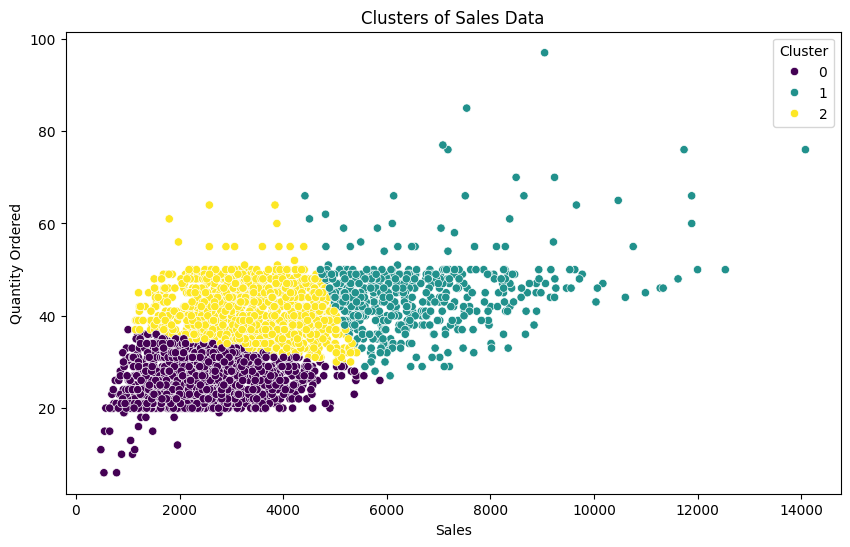

In [ ]:
# Gán nhãn cluster cho dữ liệu
clusters_with_labels = clusters.select("SALES", "QUANTITYORDERED", "features", "prediction")
clusters_with_labels.show(5)

# Chuyển kết quả sang Pandas để vẽ scatter plot
clusters_pd = clusters_with_labels.toPandas()

plt.figure(figsize=(10,6))
sns.scatterplot(x="SALES", y="QUANTITYORDERED", hue="prediction", data=clusters_pd, palette="viridis")
plt.title("Clusters of Sales Data")
plt.xlabel("Sales")
plt.ylabel("Quantity Ordered")
plt.legend(title="Cluster")
plt.show()


In [ ]:
lr_df = df.select("SALES", "QUANTITYORDERED", "PRICEEACH").na.drop()
# Đổi tên cột SALES thành label
lr_df = lr_df.withColumnRenamed("SALES", "label")

# Bước 1: Gom các đặc trưng thành một vector
assembler_lr = VectorAssembler(inputCols=["QUANTITYORDERED", "PRICEEACH"], outputCol="assembled_features")

# Bước 2: Chuẩn hóa các đặc trưng
scaler = StandardScaler(inputCol="assembled_features", outputCol="features", withMean=True, withStd=True)

# Bước 3: Định nghĩa mô hình Linear Regression
lr = LinearRegression(featuresCol="features", labelCol="label")

# Xây dựng Pipeline
pipeline = Pipeline(stages=[assembler_lr, scaler, lr])

# Chia dữ liệu thành tập huấn luyện và kiểm tra
train_data, test_data = lr_df.randomSplit([0.8, 0.2], seed=42)

# Xây dựng lưới tham số cho Linear Regression
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01, 0.001, 0.0001]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0]) \
    .addGrid(lr.maxIter, [10, 50, 100]) \
    .addGrid(lr.tol, [1e-4, 1e-5]) \
    .build()

# Tạo evaluator cho RMSE
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

# Thiết lập CrossValidator với 5 folds
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator_rmse,
                          numFolds=5)

# Huấn luyện mô hình với cross validation trên tập train
cvModel = crossval.fit(train_data)

# Dự đoán trên tập test
predictions = cvModel.transform(test_data)

# Tính RMSE
rmse = evaluator_rmse.evaluate(predictions)
print("Cross-Validated Linear Regression RMSE:", rmse)

# Tính R²
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print("Cross-Validated Linear Regression R2:", r2)

Cross-Validated Linear Regression RMSE: 911.9952180620191
Cross-Validated Linear Regression R2: 0.7495774255505216


In [ ]:
df_opt = df.repartition(100)
df_opt.cache()

# Sử dụng broadcast variable: ánh xạ PRODUCTLINE sang category
product_mapping = {
    "Classic Cars": "Vintage",
    "Motorcycles": "Vehicles",
    "Planes": "Aviation",
    "Ships": "Nautical",
    "Trains": "Transport",
    "Trucks and Buses": "Transport",
    "Vintage Cars": "Vintage"
}
broadcast_mapping = df.sparkSession.sparkContext.broadcast(product_mapping)

# Định nghĩa UDF sử dụng broadcast variable

def map_product(productline):
    return broadcast_mapping.value.get(productline, "Other")
map_product_udf = udf(map_product, StringType())
df_opt = df_opt.withColumn("PRODUCT_CATEGORY", map_product_udf(col("PRODUCTLINE")))

# Ví dụ sử dụng accumulator để đếm số dòng xử lý
accumulator = df.sparkSession.sparkContext.accumulator(0)
def count_rows(row):
    accumulator.add(1)
    return row
_ = df_opt.rdd.map(count_rows).count()
print("Total rows processed (accumulator):", accumulator.value)

Total rows processed (accumulator): 2823


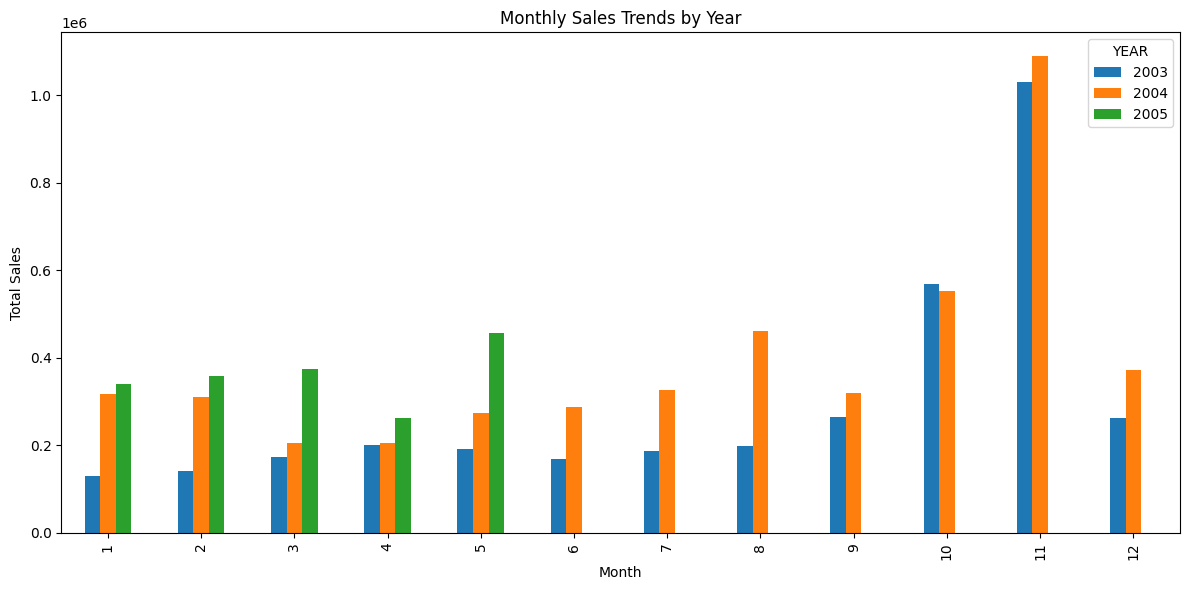

Report generated: top_products_report.csv


In [ ]:
monthly_pd = monthly_trends.toPandas()
# Tạo pivot table: các cột là các năm, chỉ số theo tháng
pivot = monthly_pd.pivot(index="MONTH", columns="YEAR", values="monthly_sales")
pivot.plot(kind="bar", figsize=(12,6))
plt.title("Monthly Sales Trends by Year")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.show()

# Xuất báo cáo top sản phẩm
top_products.toPandas().to_csv("top_products_report.csv", index=False)
print("Report generated: top_products_report.csv")
